# Purpose
The purpose of this code is to identify PMR from samples of DNA across many different cancers and test the algorithm

# Code

Tell ipython to reload modules so we can update other files

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [11]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import swifter
import matplotlib.pyplot as plt
from methylation_utils.methylation_utils.analyzer import MethylationAnalyzerHelper
from methylation_utils.methylation_utils.plot import MethPlot, ChromIdeoPlot
from methylation_utils.methylation_utils.utils import compare_bed_dfs
from methylation_utils.generic_utils import instantiate_progress_bar
from pybedtools import BedTool
import pyarrow.feather as feather

In [12]:
INCLUDE_NORMAL_SAMPLES = False

## Samples

In [13]:
SAMPLES_FILE = "data/old_data/runAll.sh.samples"

METH_DYNAMIC_FOLDER = "data/old_data/bottom/samples_meth_dynamic"
METH_REF_FILE = "data/old_data/parse450K.pl.order.lookup"

In [14]:
""" Read in the sample info and methylation reference into memory """
sample_info = pd.read_csv(SAMPLES_FILE,sep="\t")
print('Read ' + str(len(sample_info.index)) + ' samples')
meth_ref = pd.read_csv(METH_REF_FILE,sep="\t")
cancer_samples = sample_info[sample_info.sample_type != "Solid Tissue Normal"]

Read 9714 samples


## Choose regions

In [15]:
DEBUG = False

""" For individual samples """
METH_INTERMEDIATE_HIGH_CUTOFF = 70
METH_INTERMEDIATE_LOW_CUTOFF = 20

""" For combined samples """
# Number of samples that need to have intermediate methylation at a site for the site to be considered intermediatly methylated
if INCLUDE_NORMAL_SAMPLES:
    CUTOFF_INTERMEDIATE_VAL = len(sample_info.index) / 2
else:
    CUTOFF_INTERMEDIATE_VAL = len(cancer_samples.index) * 0.5

# Percent of markers that need to be intermediatly methylated in a window
CUTOFF_PCT = 0.60

LENGTH_CUTTOFF = 1000
COUNT_CUTTOFF = 20
COVERAGE_CUTOFF = 0.75

In [16]:
windows_df = feather.read_feather("shared_data/windows_df.feather" if INCLUDE_NORMAL_SAMPLES else "shared_data/windows_df.cancer.feather")
zho_common_pmds_df = feather.read_feather(
    "shared_data/zho_common_pmds_df.feather"
)
meth_ref_sorted = feather.read_feather(
    "shared_data/meth_ref_sorted.feather" if INCLUDE_NORMAL_SAMPLES else "shared_data/meth_ref_sorted.cancer.feather"
)
centromere_telomere_df = pd.read_csv(
    "files/centromere_telomere.txt", sep="\t", skiprows=[0]
)

In [17]:
windows_df

,CpG_chrm,CpG_beg,CpG_end,start_idx,end_idx,count_above_pct,count_in_window,count_in_end_tail,length,chrom_num,coverage_percentage
0,chr1,898802,898802,76,76,1,1,0,0,1,1.0
1,chr1,904054,904054,83,83,1,1,0,0,1,1.0
2,chr1,908110,908110,88,88,1,1,0,0,1,1.0
3,chr1,910429,924641,93,128,15,24,0,14212,1,0.9721059223474683
4,chr1,930479,930479,142,142,1,1,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
16814,chr9,137837099,137837099,473816,473816,1,1,0,0,9,1.0
16815,chr9,137876462,137876462,473824,473824,1,1,0,0,9,1.0
16816,chr9,137877146,137919088,473826,473838,6,8,1,41942,9,0.7524753292869235
16817,chr9,138045126,138045126,473852,473852,1,1,0,0,9,1.0


In [18]:
helper = MethylationAnalyzerHelper(
    upper_cutoff=METH_INTERMEDIATE_HIGH_CUTOFF,
    lower_cutoff=METH_INTERMEDIATE_LOW_CUTOFF,
    dmr_percent_cutoff=CUTOFF_PCT,
    sample_cutoff_val_low=CUTOFF_INTERMEDIATE_VAL,
    debug=DEBUG,
    optimize_for_humans=False,
)

In [19]:
windows_df["coverage_percentage"] = windows_df["coverage_percentage"].astype(float)
windows_df

,CpG_chrm,CpG_beg,CpG_end,start_idx,end_idx,count_above_pct,count_in_window,count_in_end_tail,length,chrom_num,coverage_percentage
0,chr1,898802,898802,76,76,1,1,0,0,1,1.000000
1,chr1,904054,904054,83,83,1,1,0,0,1,1.000000
2,chr1,908110,908110,88,88,1,1,0,0,1,1.000000
3,chr1,910429,924641,93,128,15,24,0,14212,1,0.972106
4,chr1,930479,930479,142,142,1,1,0,0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
16814,chr9,137837099,137837099,473816,473816,1,1,0,0,9,1.000000
16815,chr9,137876462,137876462,473824,473824,1,1,0,0,9,1.000000
16816,chr9,137877146,137919088,473826,473838,6,8,1,41942,9,0.752475
16817,chr9,138045126,138045126,473852,473852,1,1,0,0,9,1.000000


In [20]:
centromere_telomere_bed = BedTool.from_dataframe(
    centromere_telomere_df[["chrom", "chromStart", "chromEnd"]]
)

In [21]:
windows_bed = BedTool.from_dataframe(windows_df[["CpG_chrm", "CpG_beg", "CpG_end"]])

In [22]:
filtered_bed = windows_bed.subtract(centromere_telomere_bed)

In [23]:
filtered_data = filtered_bed.to_dataframe()
filtered_data["length"] = filtered_data["end"] - filtered_data["start"]

In [24]:
filtered_data

,chrom,start,end,length
0,chr1,898802,898802,0
1,chr1,904054,904054,0
2,chr1,908110,908110,0
3,chr1,910429,924641,14212
4,chr1,930479,930479,0
...,...,...,...,...
16806,chr9,137837099,137837099,0
16807,chr9,137876462,137876462,0
16808,chr9,137877146,137919088,41942
16809,chr9,138045126,138045126,0


In [25]:
all_samples = feather.read_feather("shared_data/all_samples.feather" if INCLUDE_NORMAL_SAMPLES else "shared_data/all_samples.cancer.feather")
all_samples

,CpG_chrm,CpG_beg,TCGA-EX-A1H6-01B,TCGA-C5-A7CM-01A,TCGA-C5-A2M1-01A,TCGA-LP-A5U2-01A,TCGA-EK-A3GK-01A,TCGA-Q1-A73P-01A,TCGA-UC-A7PI-01A,TCGA-JX-A3Q8-01A,...,TCGA-EW-A1P1-01A,TCGA-OL-A66L-01A,TCGA-AR-A0TR-01A,TCGA-BH-A0HA-01A,TCGA-BH-A1ES-06A,TCGA-E2-A15J-01A,TCGA-B6-A40C-01A,TCGA-E9-A1QZ-01A,TCGA-S3-AA10-01A,chrom_num
0,chr1,15864.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,chr1,18826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,chr1,29406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,chr1,29424.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,chr1,29434.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473873,chr22,50783822.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
473874,chr22,50784090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
473875,chr22,50784300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
473876,chr22,50784914.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22


In [26]:
filtered_data["length"] = filtered_data["end"] - filtered_data["start"]

In [27]:
meth_ref_sorted

,index,key,CpG_chrm,CpG_beg,CpG_end,probe_strand,probeID,genesUniq,geneNames,transcriptTypes,transcriptIDs,distToTSS,CGI,CGIposition,intermediate_count
0,0,cg13869341,chr1,15864.0,15866.0,-,cg13869341,WASH7P,WASH7P,unprocessed_pseudogene,ENST00000488147.1,13706,None,None,NaN
1,1,cg14008030,chr1,18826.0,18828.0,-,cg14008030,MIR6859-1;WASH7P,MIR6859-1;WASH7P,miRNA;unprocessed_pseudogene,ENST00000619216.1;ENST00000488147.1,-1390;10744,None,None,NaN
2,2,cg12045430,chr1,29406.0,29408.0,-,cg12045430,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-959;-860;-147;164,CGI:chr1:28735-29737,Island,NaN
3,3,cg20826792,chr1,29424.0,29426.0,-,cg20826792,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-941;-842;-129;146,CGI:chr1:28735-29737,Island,NaN
4,4,cg00381604,chr1,29434.0,29436.0,-,cg00381604,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-931;-832;-119;136,CGI:chr1:28735-29737,Island,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485572,485572,cg24238852,None,NaN,NaN,*,cg24238852,None,None,None,None,None,None,None,NaN
485573,485573,cg15254640,None,NaN,NaN,*,cg15254640,None,None,None,None,None,None,None,NaN
485574,485574,cg24336839,None,NaN,NaN,*,cg24336839,None,None,None,None,None,None,None,NaN
485575,485575,cg11478607,None,NaN,NaN,*,cg11478607,None,None,None,None,None,None,None,NaN


In [28]:
meth_ref_modified = meth_ref_sorted.dropna(subset=["CpG_chrm"])

In [29]:
meth_ref_modified["chrom_num"] = meth_ref_modified["CpG_chrm"].str.extract("(\d+)")
meth_ref_modified.dropna(subset=["chrom_num"], inplace=True)
meth_ref_modified["chrom_num"] = meth_ref_modified["chrom_num"].astype(int)
meth_ref_modified

/tmp/ipykernel_1379512/3183020432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meth_ref_modified["chrom_num"] = meth_ref_modified["CpG_chrm"].str.extract("(\d+)")
/tmp/ipykernel_1379512/3183020432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meth_ref_modified.dropna(subset=["chrom_num"], inplace=True)
/tmp/ipykernel_1379512/3183020432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,index,key,CpG_chrm,CpG_beg,CpG_end,probe_strand,probeID,genesUniq,geneNames,transcriptTypes,transcriptIDs,distToTSS,CGI,CGIposition,intermediate_count,chrom_num
0,0,cg13869341,chr1,15864.0,15866.0,-,cg13869341,WASH7P,WASH7P,unprocessed_pseudogene,ENST00000488147.1,13706,None,None,NaN,1
1,1,cg14008030,chr1,18826.0,18828.0,-,cg14008030,MIR6859-1;WASH7P,MIR6859-1;WASH7P,miRNA;unprocessed_pseudogene,ENST00000619216.1;ENST00000488147.1,-1390;10744,None,None,NaN,1
2,2,cg12045430,chr1,29406.0,29408.0,-,cg12045430,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-959;-860;-147;164,CGI:chr1:28735-29737,Island,NaN,1
3,3,cg20826792,chr1,29424.0,29426.0,-,cg20826792,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-941;-842;-129;146,CGI:chr1:28735-29737,Island,NaN,1
4,4,cg00381604,chr1,29434.0,29436.0,-,cg00381604,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-931;-832;-119;136,CGI:chr1:28735-29737,Island,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473873,249018,cg14008164,chr9,138214751.0,138214753.0,+,cg14008164,None,None,None,None,None,None,None,NaN,9
473874,249019,cg04824555,chr9,138215523.0,138215525.0,-,cg04824555,None,None,None,None,None,None,None,NaN,9
473875,249020,cg23867978,chr9,138218976.0,138218978.0,+,cg23867978,FAM157B,FAM157B;FAM157B,transcribed_unprocessed_pseudogene;transcribed...,ENST00000446912.3;ENST00000642084.1,1909;1906,CGI:chr9:138220919-138221140,N_Shore,NaN,9
473876,249021,cg14598452,chr9,138220690.0,138220692.0,+,cg14598452,FAM157B,FAM157B;FAM157B;FAM157B,transcribed_unprocessed_pseudogene;transcribed...,ENST00000446912.3;ENST00000540522.6;ENST000006...,3623;-453;3620,CGI:chr9:138220919-138221140,N_Shore,NaN,9


In [30]:
all_samples["chrom_num"] = all_samples["CpG_chrm"].str.extract("(\d+)")
all_samples.dropna(subset=["chrom_num"], inplace=True)
all_samples["chrom_num"] = all_samples["chrom_num"].astype(int)

In [31]:
filtered_data["CpG_chrm"] = filtered_data["chrom"]
filtered_data["chrom_num"] = filtered_data["chrom"].str.extract("(\d+)").astype(int)

In [32]:
filtered_data

,chrom,start,end,length,CpG_chrm,chrom_num
0,chr1,898802,898802,0,chr1,1
1,chr1,904054,904054,0,chr1,1
2,chr1,908110,908110,0,chr1,1
3,chr1,910429,924641,14212,chr1,1
4,chr1,930479,930479,0,chr1,1
...,...,...,...,...,...,...
16806,chr9,137837099,137837099,0,chr9,9
16807,chr9,137876462,137876462,0,chr9,9
16808,chr9,137877146,137919088,41942,chr9,9
16809,chr9,138045126,138045126,0,chr9,9


In [33]:
meth_ref_modified

,index,key,CpG_chrm,CpG_beg,CpG_end,probe_strand,probeID,genesUniq,geneNames,transcriptTypes,transcriptIDs,distToTSS,CGI,CGIposition,intermediate_count,chrom_num
0,0,cg13869341,chr1,15864.0,15866.0,-,cg13869341,WASH7P,WASH7P,unprocessed_pseudogene,ENST00000488147.1,13706,None,None,NaN,1
1,1,cg14008030,chr1,18826.0,18828.0,-,cg14008030,MIR6859-1;WASH7P,MIR6859-1;WASH7P,miRNA;unprocessed_pseudogene,ENST00000619216.1;ENST00000488147.1,-1390;10744,None,None,NaN,1
2,2,cg12045430,chr1,29406.0,29408.0,-,cg12045430,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-959;-860;-147;164,CGI:chr1:28735-29737,Island,NaN,1
3,3,cg20826792,chr1,29424.0,29426.0,-,cg20826792,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-941;-842;-129;146,CGI:chr1:28735-29737,Island,NaN,1
4,4,cg00381604,chr1,29434.0,29436.0,-,cg00381604,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-931;-832;-119;136,CGI:chr1:28735-29737,Island,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473873,249018,cg14008164,chr9,138214751.0,138214753.0,+,cg14008164,None,None,None,None,None,None,None,NaN,9
473874,249019,cg04824555,chr9,138215523.0,138215525.0,-,cg04824555,None,None,None,None,None,None,None,NaN,9
473875,249020,cg23867978,chr9,138218976.0,138218978.0,+,cg23867978,FAM157B,FAM157B;FAM157B,transcribed_unprocessed_pseudogene;transcribed...,ENST00000446912.3;ENST00000642084.1,1909;1906,CGI:chr9:138220919-138221140,N_Shore,NaN,9
473876,249021,cg14598452,chr9,138220690.0,138220692.0,+,cg14598452,FAM157B,FAM157B;FAM157B;FAM157B,transcribed_unprocessed_pseudogene;transcribed...,ENST00000446912.3;ENST00000540522.6;ENST000006...,3623;-453;3620,CGI:chr9:138220919-138221140,N_Shore,NaN,9


In [34]:
filtered_data["count_in_window"] = filtered_data.swifter.apply(
    lambda x: (
        meth_ref_modified[
            (meth_ref_modified["CpG_beg"] >= x["start"])
            & (meth_ref_modified["CpG_end"] <= x["end"])
            & (meth_ref_modified["chrom_num"] == x["chrom_num"])
            & (meth_ref_modified["intermediate_count"].isna() == False)
        ]
    ).shape[0],
    axis=1,
)

Pandas Apply:   0%|          | 0/16811 [00:00<?, ?it/s]

In [35]:
def get_percent_coverge(row):
    window_samples = all_samples[
        (all_samples["chrom_num"] == row["chrom_num"])
        & (all_samples["CpG_beg"] >= row["start"])
        & (all_samples["CpG_beg"] <= row["end"])
    ]
    window_meth_vals = window_samples.drop(columns=["CpG_chrm", "chrom_num", "CpG_beg"])
    count_with_value = window_meth_vals.notnull().sum().sum()
    total_count = window_meth_vals.size
    return np.where(total_count == 0, 0, count_with_value / total_count)

In [36]:
filtered_data["coverage_percentage"] = filtered_data.swifter.apply(get_percent_coverge, axis=1)

Pandas Apply:   0%|          | 0/16811 [00:00<?, ?it/s]

In [37]:
def populate_region_stats(meth_windows):
    progress_bar = instantiate_progress_bar(max=len(meth_windows.index))
    percentages = []
    dist_to_next = []

    for index, window in meth_windows.iterrows():
        if (
            index + 1 < len(meth_windows)
            and meth_windows.iloc[index + 1]["chrom"] == window["chrom"]
        ):
            dist_to_next.append(meth_windows.iloc[index + 1]["start"] - window["end"])
        else:
            dist_to_next.append(np.nan)
    for index, window in meth_windows.iterrows():
        progress_bar.value += 1

        pmrs, percent, int_count, total_count = helper.check_percent_in_region(
            meth_ref_sorted,
            window["CpG_chrm"],
            window["start"],
            window["end"],
        )
        percentages.append(percent)
    return pd.concat(
        [
            meth_windows.reset_index(drop=True),
            pd.DataFrame(percentages, columns=["intermediate_percent"]).reset_index(
                drop=True
            ),
            pd.DataFrame(dist_to_next, columns=["dist_to_next"]).reset_index(drop=True),
        ],
        axis=1,
    )

In [38]:
len(filtered_data)

16811

In [39]:
windows_to_analyze = filtered_data[
    (filtered_data["length"] > LENGTH_CUTTOFF)
    & (filtered_data["count_in_window"] > COUNT_CUTTOFF)
    & (filtered_data["coverage_percentage"] > COVERAGE_CUTOFF)
]
windows_to_analyze = windows_to_analyze.reset_index()

In [40]:
len(windows_to_analyze)

145

In [41]:
windows_to_analyze = populate_region_stats(windows_to_analyze)

IntProgress(value=0, max=145)

In [42]:
centromere_telomere_df

,#bin,chrom,chromStart,chromEnd,ix,n,size,type,bridge
0,23,chr1,121535434,124535434,1270,N,3000000,centromere,no
1,585,chr1,0,10000,1,N,10000,telomere,no
2,2486,chr1,249240621,249250621,2302,N,10000,telomere,no
3,20,chr2,92326171,95326171,770,N,3000000,centromere,no
4,585,chr2,0,10000,1,N,10000,telomere,no
...,...,...,...,...,...,...,...,...,...
65,585,chr21,0,10000,1,N,10000,telomere,no
66,952,chr21,48119895,48129895,515,N,10000,telomere,no
67,10,chr22,13000000,16000000,3,N,3000000,centromere,no
68,585,chr22,0,10000,1,N,10000,telomere,no


In [43]:
windows_to_analyze = windows_to_analyze[windows_to_analyze["intermediate_percent"] >= CUTOFF_PCT]

In [44]:
windows_to_analyze

,index,chrom,start,end,length,CpG_chrm,chrom_num,count_in_window,coverage_percentage,intermediate_percent,dist_to_next
0,3,chr1,910429,924641,14212,chr1,1,23,0.9721059223474683,0.625000,1488917.0
1,121,chr1,2413558,2442415,28857,chr1,1,21,0.9091420176851146,0.636364,187199.0
2,138,chr1,2629614,2876138,246524,chr1,1,49,0.8648416532474503,0.620000,46101.0
3,146,chr1,2922239,3020020,97781,chr1,1,46,0.8483665035515324,0.617021,4240.0
4,149,chr1,3024260,3084437,60177,chr1,1,40,0.9081625433074708,0.634146,55150.0
...,...,...,...,...,...,...,...,...,...,...,...
140,16054,chr8,98947373,99859902,912529,chr8,8,23,0.8825519947381552,0.666667,42230004.0
141,16235,chr8,142089906,142252156,162250,chr8,8,41,0.8571945723951117,0.642857,931260.0
142,16267,chr8,143183416,143248530,65114,chr8,8,23,0.8875442379249797,0.708333,NaN
143,16722,chr9,135500901,135804653,303752,chr9,9,45,0.8632304673407073,0.630435,1630464.0


In [45]:
count_per_chrom = windows_to_analyze.groupby('chrom')

In [46]:
count_per_chrom.size()

chrom
chr1     18
chr10     8
chr11    13
chr12     3
chr13     2
chr14     6
chr15     3
chr16    10
chr17     7
chr19     8
chr2     13
chr20     6
chr21     1
chr22     3
chr3      1
chr4     10
chr5      4
chr6     11
chr7     11
chr8      5
chr9      2
dtype: int64

Text(0, 0.5, 'Number of Regions')

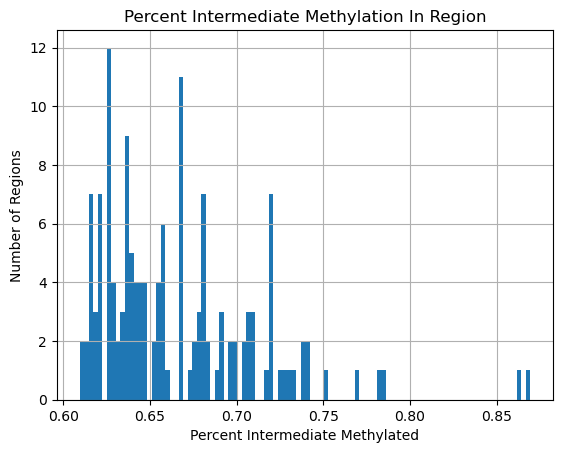

In [47]:
windows_to_analyze["intermediate_percent"].hist(bins=100)
plt.title("Percent Intermediate Methylation In Region")
plt.xlabel("Percent Intermediate Methylated")
plt.ylabel("Number of Regions")

In [48]:
windows_to_analyze["intermediate_percent"].describe().apply(
    lambda x: "{:,.2f}".format(x)
)

count    145.00
mean       0.67
std        0.05
min        0.61
25%        0.63
50%        0.66
75%        0.69
max        0.87
Name: intermediate_percent, dtype: object

Text(0, 0.5, 'Number of Regions')

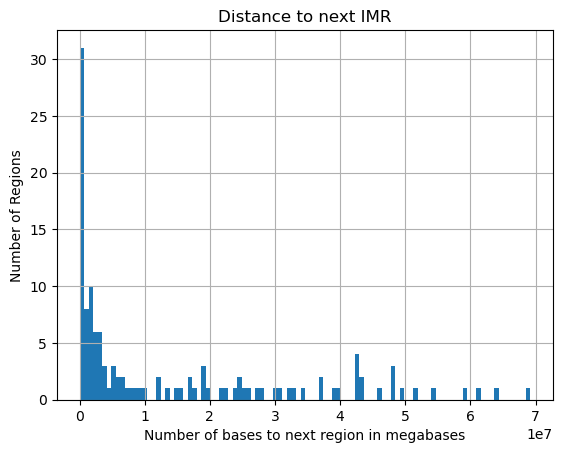

In [49]:
windows_to_analyze["dist_to_next"].hist(bins=100)
plt.title("Distance to next IMR")
plt.xlabel("Number of bases to next region in megabases")
plt.ylabel("Number of Regions")

In [50]:
windows_to_analyze["dist_to_next"].describe().apply(lambda x: "{:,.0f}".format(x))

count           124
mean     14,159,358
std      18,060,883
min           4,240
25%         716,157
50%       3,773,576
75%      24,497,760
max      69,214,045
Name: dist_to_next, dtype: object

In [51]:
zho_common_pmds_df

,chrom,start,end,length
0,chr1,0,200000,200000
1,chr1,500000,700000,200000
2,chr1,2800000,3400000,600000
3,chr1,3500000,3600000,100000
4,chr1,3900000,5800000,1900000
...,...,...,...,...
1989,chr9,131000000,131100000,100000
1990,chr9,132100000,132200000,100000
1991,chr9,133600000,133700000,100000
1992,chr9,134500000,135800000,1300000


In [52]:
windows_df

,CpG_chrm,CpG_beg,CpG_end,start_idx,end_idx,count_above_pct,count_in_window,count_in_end_tail,length,chrom_num,coverage_percentage
0,chr1,898802,898802,76,76,1,1,0,0,1,1.000000
1,chr1,904054,904054,83,83,1,1,0,0,1,1.000000
2,chr1,908110,908110,88,88,1,1,0,0,1,1.000000
3,chr1,910429,924641,93,128,15,24,0,14212,1,0.972106
4,chr1,930479,930479,142,142,1,1,0,0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
16814,chr9,137837099,137837099,473816,473816,1,1,0,0,9,1.000000
16815,chr9,137876462,137876462,473824,473824,1,1,0,0,9,1.000000
16816,chr9,137877146,137919088,473826,473838,6,8,1,41942,9,0.752475
16817,chr9,138045126,138045126,473852,473852,1,1,0,0,9,1.000000


Shared: 226439160 Unique to identified: 130133468 Unique to Zhou: 1177660840
Percent shared (to Zhou): 0.16126996652660067 Percent shared (to identified): 0.6350519627783457
Percent unique (Zhou): 0.8387300334733994 Percent unique (identified): 0.3649612296590088
/tmp/venn.jpg


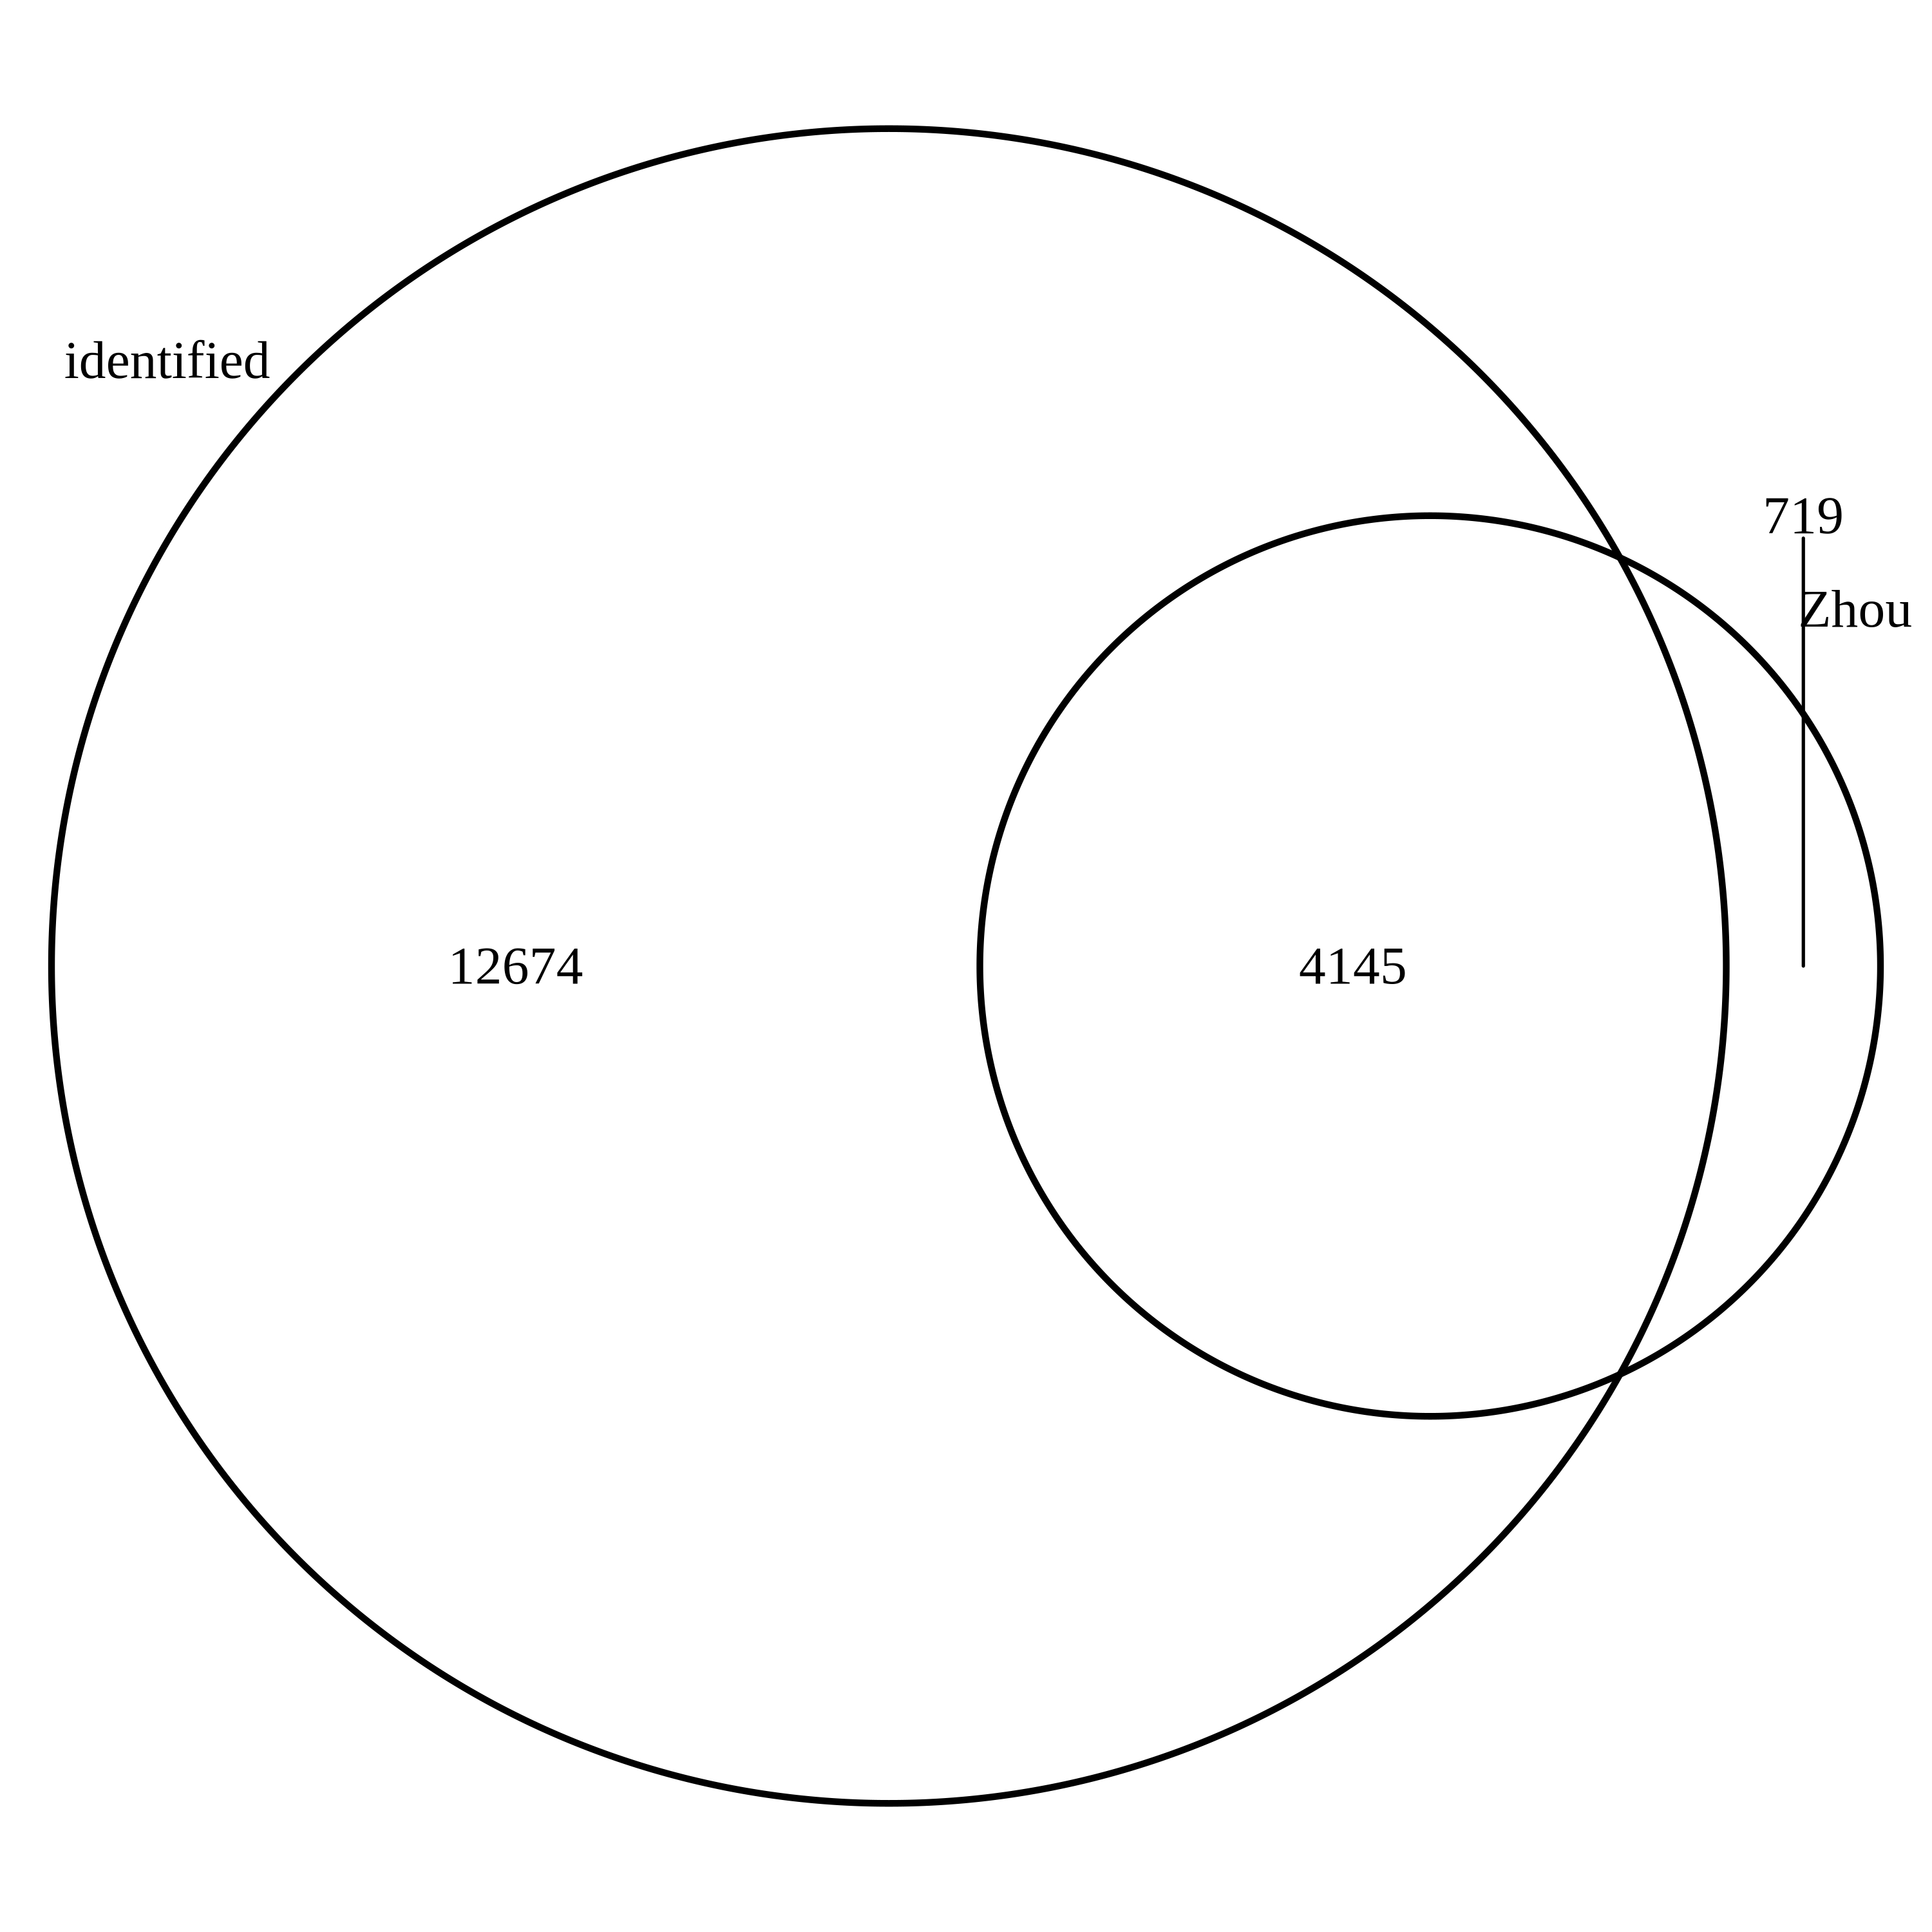

(<BedTool(/tmp/pybedtools.ljptenzw.tmp)>,
 <BedTool(/tmp/pybedtools.ivl62ch2.tmp)>,
 <BedTool(/tmp/pybedtools.uer0_tki.tmp)>)

In [53]:
compare_bed_dfs(windows_df, zho_common_pmds_df, "identified", "Zhou", df1_colms=["CpG_chrm", "CpG_beg", "CpG_end"])

In [54]:
windows_to_analyze

,index,chrom,start,end,length,CpG_chrm,chrom_num,count_in_window,coverage_percentage,intermediate_percent,dist_to_next
0,3,chr1,910429,924641,14212,chr1,1,23,0.9721059223474683,0.625000,1488917.0
1,121,chr1,2413558,2442415,28857,chr1,1,21,0.9091420176851146,0.636364,187199.0
2,138,chr1,2629614,2876138,246524,chr1,1,49,0.8648416532474503,0.620000,46101.0
3,146,chr1,2922239,3020020,97781,chr1,1,46,0.8483665035515324,0.617021,4240.0
4,149,chr1,3024260,3084437,60177,chr1,1,40,0.9081625433074708,0.634146,55150.0
...,...,...,...,...,...,...,...,...,...,...,...
140,16054,chr8,98947373,99859902,912529,chr8,8,23,0.8825519947381552,0.666667,42230004.0
141,16235,chr8,142089906,142252156,162250,chr8,8,41,0.8571945723951117,0.642857,931260.0
142,16267,chr8,143183416,143248530,65114,chr8,8,23,0.8875442379249797,0.708333,NaN
143,16722,chr9,135500901,135804653,303752,chr9,9,45,0.8632304673407073,0.630435,1630464.0


Shared: 30256574 Unique to To analyze: 15105711 Unique to Zhou regions: 1373843426
Percent shared (to Zhou regions): 0.02154873157182537 Percent shared (to To analyze): 0.6669984547736076
Percent unique (Zhou regions): 0.9784512684281746 Percent unique (To analyze): 0.33300154522639236
/tmp/venn.jpg


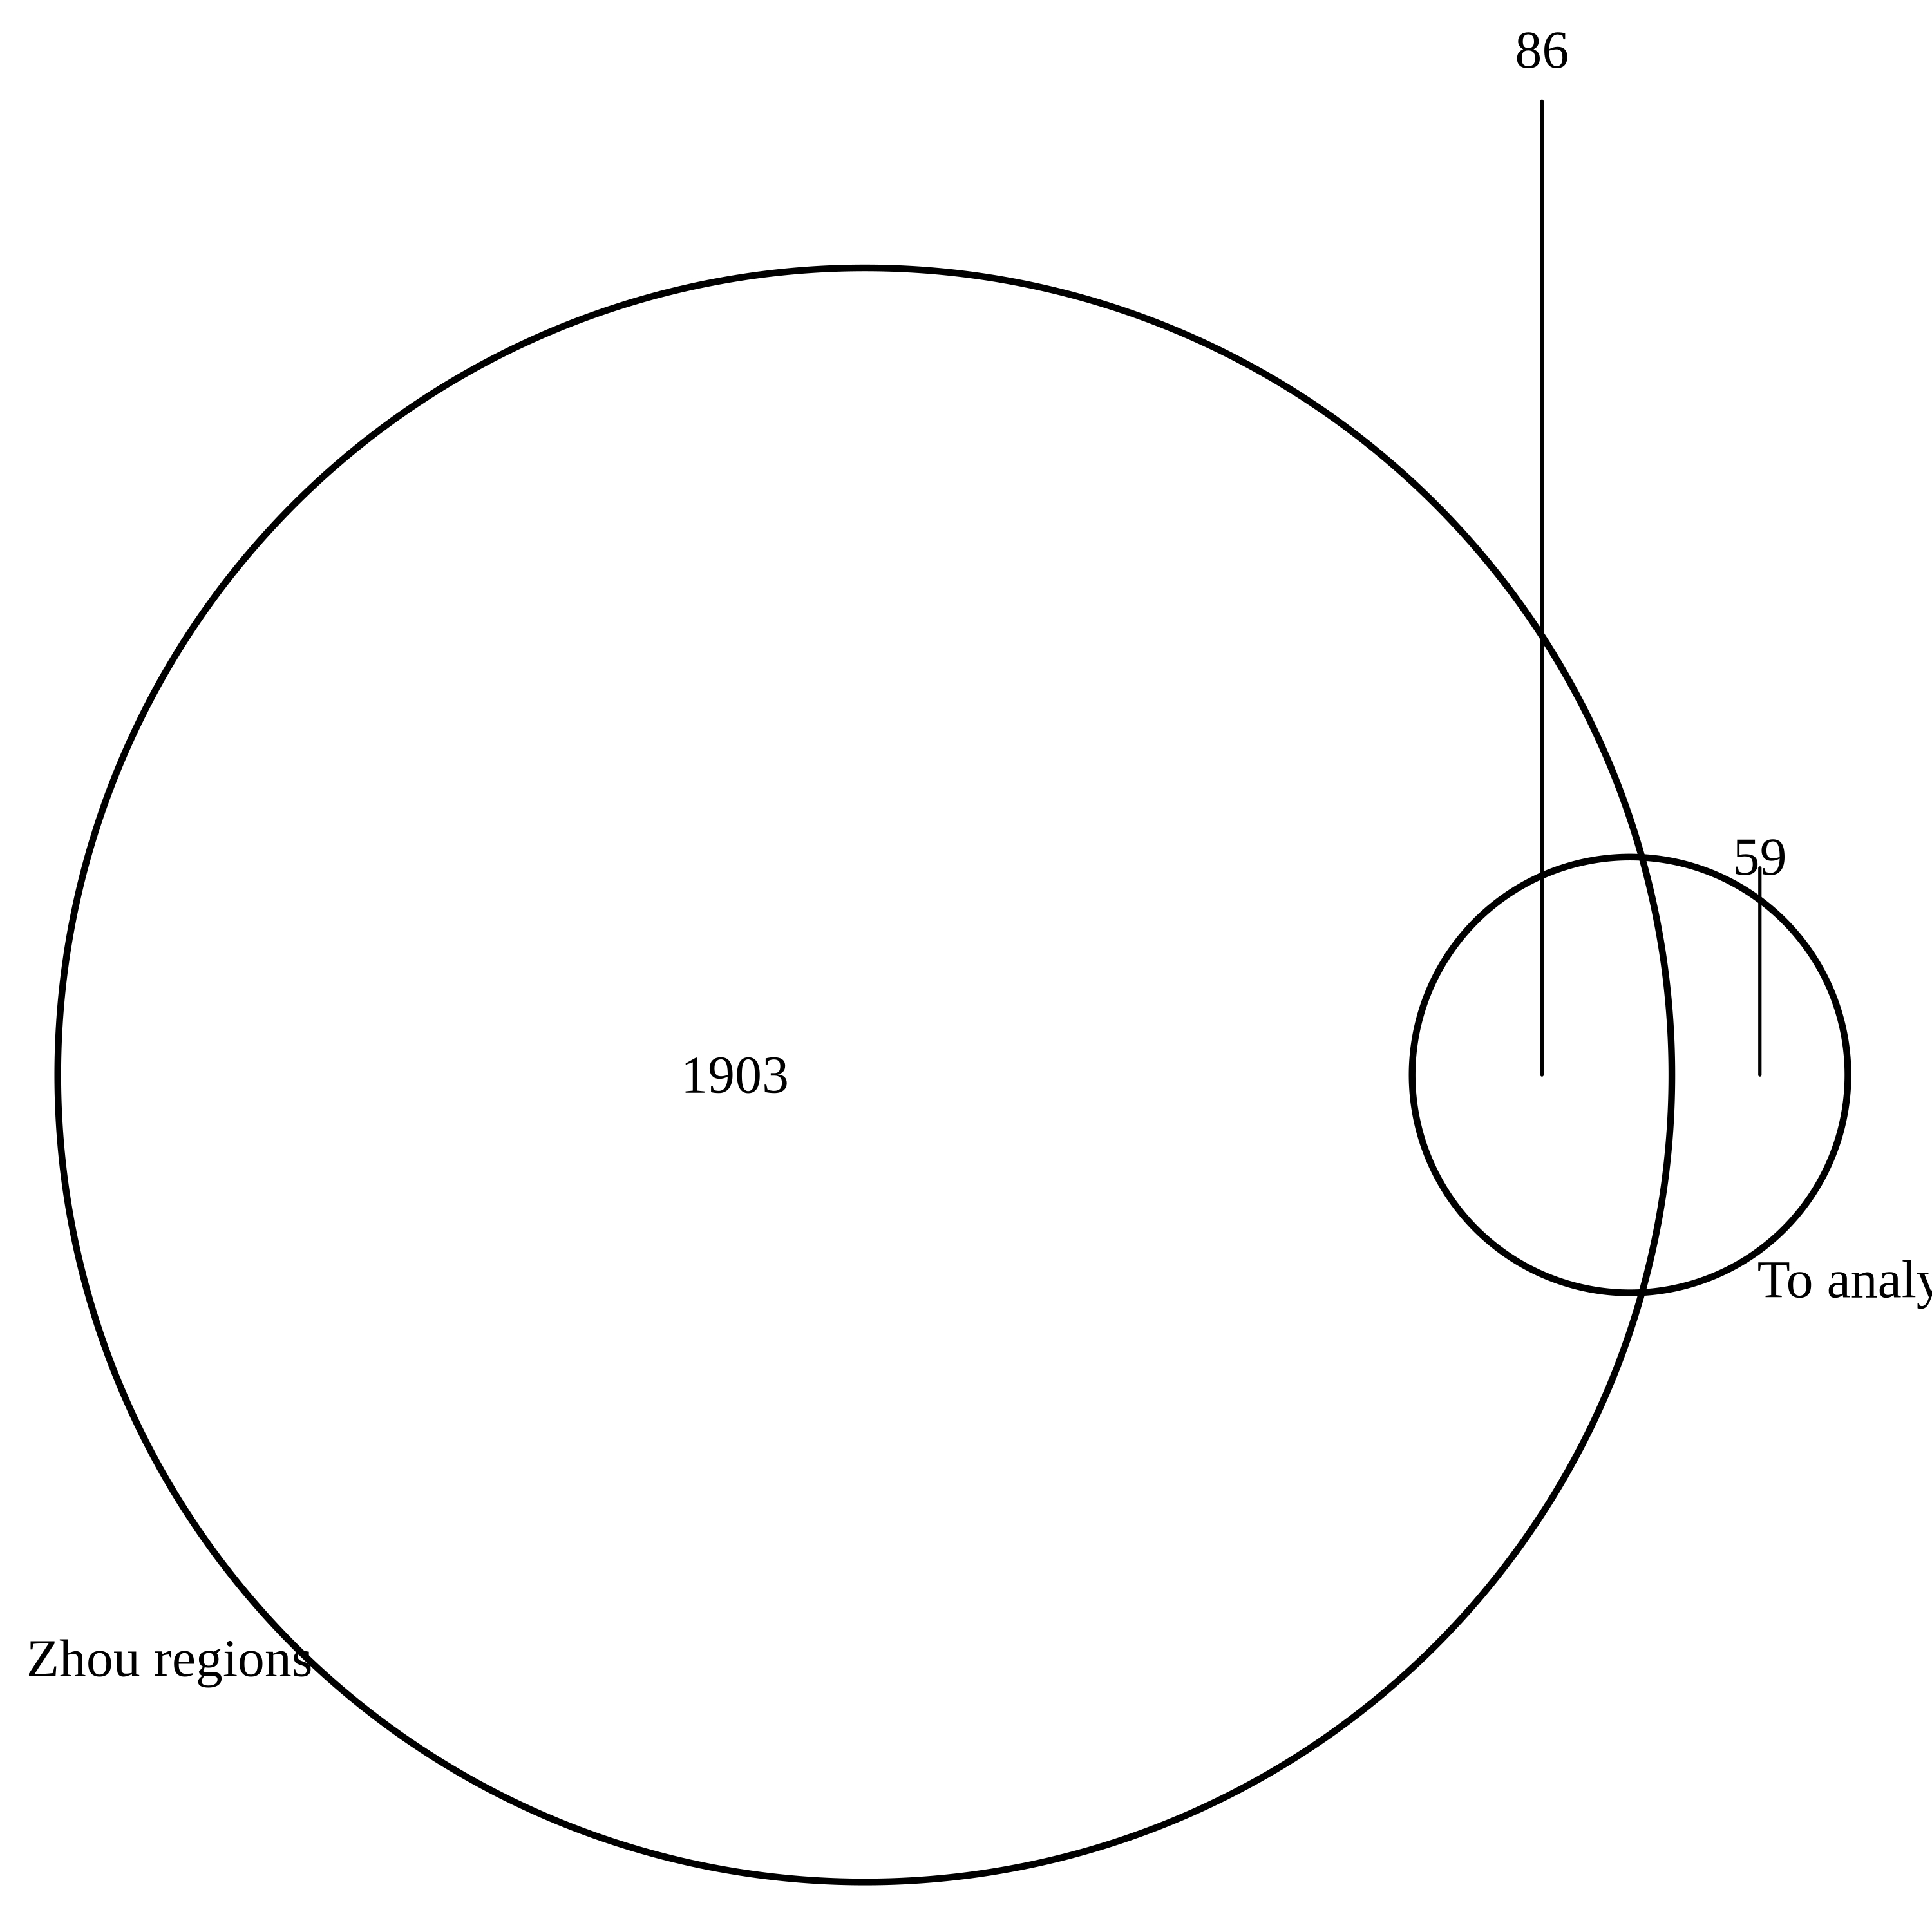

(<BedTool(/tmp/pybedtools.hp9j1rbd.tmp)>,
 <BedTool(/tmp/pybedtools.zhopv1fc.tmp)>,
 <BedTool(/tmp/pybedtools.mkbhl9dv.tmp)>)

In [55]:
compare_bed_dfs(
    windows_to_analyze,
    zho_common_pmds_df,
    "To analyze",
    "Zhou regions",
    df1_colms=["CpG_chrm", "start", "end"],
)

In [56]:
known_bed = BedTool.from_dataframe(zho_common_pmds_df[["chrom", "start", "end"]])
windows_bed = BedTool.from_dataframe(windows_to_analyze[["CpG_chrm", "start", "end"]])
known_bed.saveas(f"out/files/known_regions.bed")
windows_bed.saveas(f"out/files/regions_to_analyze.bed")

<BedTool(out/files/regions_to_analyze.bed)>

In [57]:
unique_to_known = known_bed.subtract(windows_bed)
unique_to_windows = windows_bed.subtract(known_bed)
in_both = known_bed.intersect(windows_bed)
unique_to_known.saveas(f'out/files/unique_to_known.bed')
unique_to_windows.saveas(f'out/files/unique_to_analyze.bed')
in_both.saveas(f'out/files/in_both.bed')
unique_to_known = unique_to_known.to_dataframe()
unique_to_windows = unique_to_windows.to_dataframe()
in_both = in_both.to_dataframe()

In [58]:
unique_to_known["length"] = unique_to_known["end"] - unique_to_known["start"]
unique_to_windows["length"] = unique_to_windows["end"] - unique_to_windows["start"]
in_both["length"] = in_both["end"] - in_both["start"]

In [59]:
unique_to_known = unique_to_known.sort_values(by=['length'], ascending=False)
unique_to_windows = unique_to_windows.sort_values(by=['length'], ascending=False)
in_both = in_both.sort_values(by=['length'], ascending=False)

In [60]:
methPlot = MethPlot(meth_ref_sorted, sample_info, METH_INTERMEDIATE_LOW_CUTOFF, METH_INTERMEDIATE_HIGH_CUTOFF)

In [61]:
def plot_window(chr, start, end, title):
    print(chr, start, end, title)
    methPlot.plot_multi_sample_heatmap(chroms=[chr], pos=[(start, end)], title=title)

chr1 124700000 144200000 Unique to Zhou (chr1 124700000-144200000)


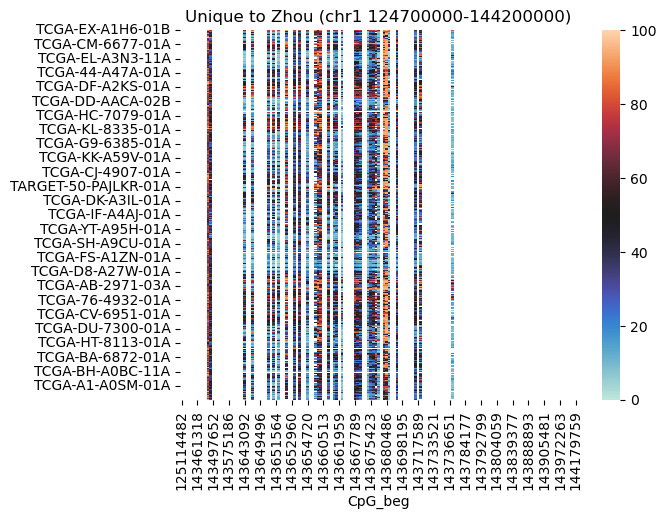

In [62]:
plot_window(unique_to_known.iloc[0]['chrom'], unique_to_known.iloc[0]['start'], unique_to_known.iloc[0]['end'], f"Unique to Zhou ({unique_to_known.iloc[0]['chrom']} {unique_to_known.iloc[0]['start']}-{unique_to_known.iloc[0]['end']})")

chr8 98947373 99859902 Unique to Chosen Windows (chr8 98947373-99859902)


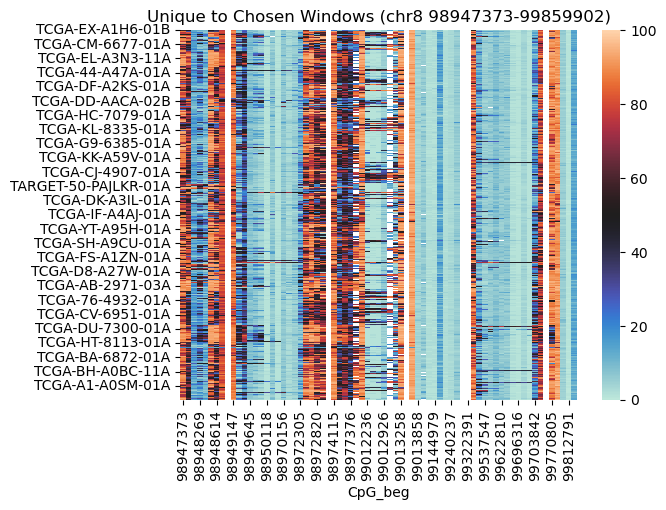

In [63]:
plot_window(unique_to_windows.iloc[0]['chrom'], unique_to_windows.iloc[0]['start'], unique_to_windows.iloc[0]['end'], f"Unique to Chosen Windows ({unique_to_windows.iloc[0]['chrom']} {unique_to_windows.iloc[0]['start']}-{unique_to_windows.iloc[0]['end']})")

chr6 100900000 104600000 Shared (chr6 100900000-104600000)


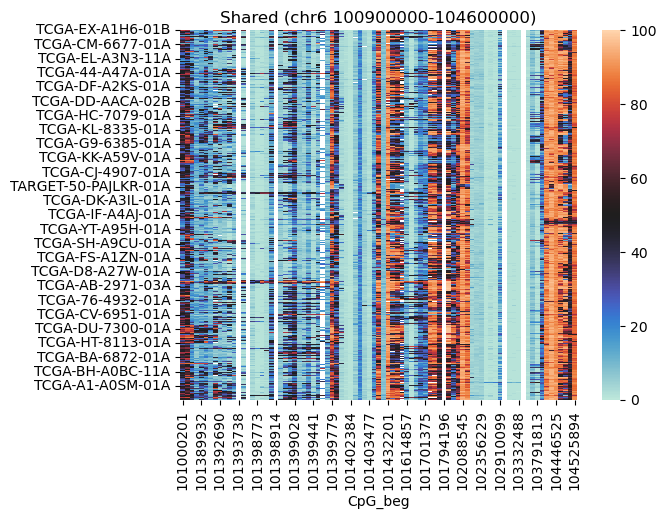

In [64]:
plot_window(in_both.iloc[0]['chrom'], in_both.iloc[0]['start'], in_both.iloc[0]['end'], f"Shared ({in_both.iloc[0]['chrom']} {in_both.iloc[0]['start']}-{in_both.iloc[0]['end']})")

In [65]:
chrom_plot = ChromIdeoPlot("files/ideogram.txt")

In [66]:
zho_remane = zho_common_pmds_df.rename(columns={'start': 'CpG_beg', 'end': 'CpG_end'})
zho_remane ['CpG_chrm'] = zho_remane['chrom'].str[3:].astype(int)

In [67]:
windows_df[["CpG_chrm", "CpG_beg", "CpG_end"]]

,CpG_chrm,CpG_beg,CpG_end
0,chr1,898802,898802
1,chr1,904054,904054
2,chr1,908110,908110
3,chr1,910429,924641
4,chr1,930479,930479
...,...,...,...
16814,chr9,137837099,137837099
16815,chr9,137876462,137876462
16816,chr9,137877146,137919088
16817,chr9,138045126,138045126


In [68]:
windows_to_analyze[["CpG_chrm", "start", "end"]]

,CpG_chrm,start,end
0,chr1,910429,924641
1,chr1,2413558,2442415
2,chr1,2629614,2876138
3,chr1,2922239,3020020
4,chr1,3024260,3084437
...,...,...,...
140,chr8,98947373,99859902
141,chr8,142089906,142252156
142,chr8,143183416,143248530
143,chr9,135500901,135804653


In [69]:
zho_remane[["chrom", "CpG_beg", "CpG_end"]]

,chrom,CpG_beg,CpG_end
0,chr1,0,200000
1,chr1,500000,700000
2,chr1,2800000,3400000
3,chr1,3500000,3600000
4,chr1,3900000,5800000
...,...,...,...
1989,chr9,131000000,131100000
1990,chr9,132100000,132200000
1991,chr9,133600000,133700000
1992,chr9,134500000,135800000


In [70]:
centromere_telomere_df[ ["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
0,chr1,121535434,124535434
1,chr1,0,10000
2,chr1,249240621,249250621
3,chr2,92326171,95326171
4,chr2,0,10000
...,...,...,...
65,chr21,0,10000
66,chr21,48119895,48129895
67,chr22,13000000,16000000
68,chr22,0,10000


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/methylation_utils/methylation_utils/plot.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo["width"] = ideo.end - ideo.start
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/methylation_utils/methylation_utils/plot.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo["colors"] = ideo["gieStain"].apply(la

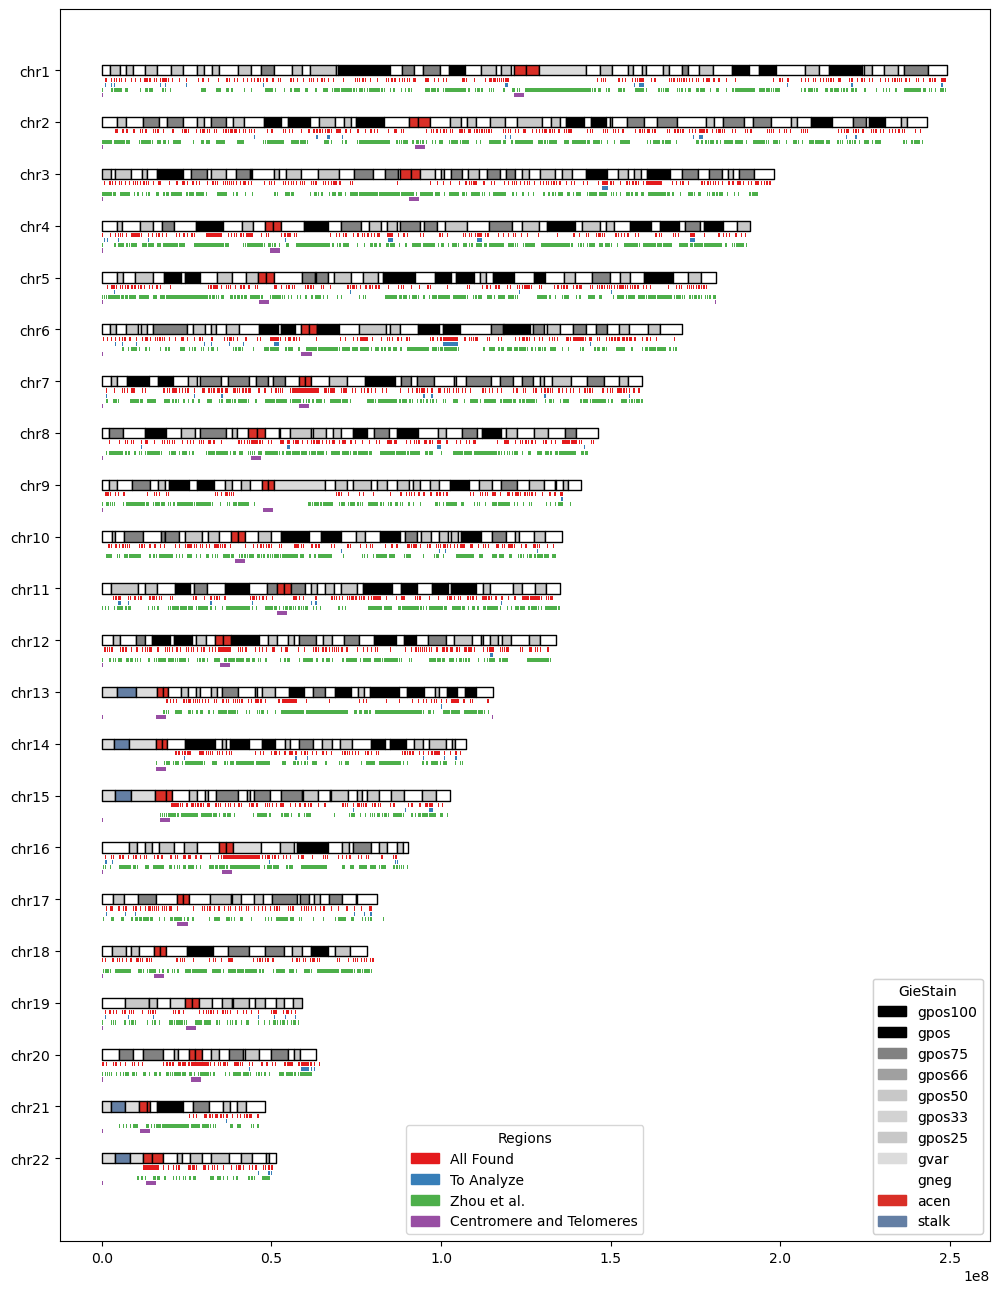

In [71]:
chrom_plot.plot_chromosome_regions(
    region_data=[
        windows_df,
        windows_to_analyze,
        zho_remane,
        centromere_telomere_df,
    ],
    region_labels=[
        "All Found",
        "To Analyze",
        "Zhou et al.",
        "Centromere and Telomeres",
    ],
    cols=[
        ["CpG_chrm", "CpG_beg", "CpG_end"],
        ["CpG_chrm", "start", "end"],
        ["chrom", "CpG_beg", "CpG_end"],
        ["chrom", "chromStart", "chromEnd"],
    ],
    # chromosome_list=["chr1"],
    min_width=250000,
)

In [72]:
chrom_plot.plot_chromosome_regions(
    region_data=[
        windows_df,
        windows_to_analyze,
        zho_remane,
        centromere_telomere_df,
    ],
    region_labels=[
        "All Found",
        "To Analyze",
        "Zhou et al.",
        # "Centromere and Telomeres",
    ],
    cols=[
        ["CpG_chrm", "CpG_beg", "CpG_end"],
        ["CpG_chrm", "start", "end"],
        ["chrom", "CpG_beg", "CpG_end"],
        # ["chrom", "chromStart", "chromEnd"],
    ],
    chromosome_list=["chr1"],
    min_width=300000,
    figsize=(25, 15),
    # region_positions=[0, 11777881],
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/methylation_utils/methylation_utils/plot.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo["width"] = ideo.end - ideo.start
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/methylation_utils/methylation_utils/plot.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo["colors"] = ideo["gieStain"].apply(la

IndexError: list index out of range

In [ ]:
windows_to_analyze[windows_to_analyze["chrom"] == "chr1"]

,index,chrom,start,end,length,CpG_chrm,chrom_num,count_in_window,coverage_percentage,intermediate_percent,dist_to_next
0,3,chr1,910429,924641,14212,chr1,1,23,0.9721059223474683,0.625000,1488917.0
4,149,chr1,3024260,3084437,60177,chr1,1,40,0.9081625433074708,0.634146,55150.0
6,204,chr1,3533662,3579462,45800,chr1,1,21,0.9539062118772264,0.636364,13665938.0
8,463,chr1,18684521,18875365,190844,chr1,1,24,0.9119062565390249,0.600000,6055709.0
9,556,chr1,24931074,25067262,136188,chr1,1,33,0.9310898223204782,0.647059,22366277.0
10,896,chr1,47433539,47711588,278049,chr1,1,40,0.9317782378651944,0.658537,42999318.0
11,1049,chr1,90710906,90836404,125498,chr1,1,41,0.9752185635577273,0.761905,28143609.0
14,1340,chr1,158254130,159778419,1524289,chr1,1,46,0.8393315755634596,0.617021,42231951.0
15,1559,chr1,202010370,202134926,124556,chr1,1,24,0.9716388394496709,0.680000,18752091.0
17,1883,chr1,247517799,247855513,337714,chr1,1,22,0.8465928779632688,0.652174,NaN


In [ ]:
windows_to_analyze["coverage_percentage"] = windows_to_analyze["coverage_percentage"].astype(str)

In [ ]:
feather.write_feather(windows_to_analyze, "shared_data/windows_to_analyze.feather" if INCLUDE_NORMAL_SAMPLES else "shared_data/windows_to_analyze.cancer.feather")